In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
from  more_itertools import unique_everseen
from scipy.stats import pearsonr, spearmanr
from sklearn import linear_model
from sklearn.metrics import r2_score
from adjustText import adjust_text
from functools import partial
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
pd.set_option('chained_assignment',None)
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def clean_strings(val):
    if isinstance(val, str):
        clean = val.replace('<', '')
        clean = clean.replace('>', '')
        try:
            return(float(clean))
        except ValueError:
            return(np.nan)
    elif isinstance(val, float) or isinstance(val, int):
        return(float(val))
    else:
        return(np.nan)

In [3]:
main_data = pd.read_csv('C:/Users/lzoeckler/Desktop/4plex/output_data/final_dilutions.csv')
val_cols = ['HRP2_pg_ml', 'LDH_Pan_pg_ml', 'CRP_ng_ml']
main_data[val_cols] = main_data[val_cols].applymap(clean_strings)
main_data = main_data[['patient_id', 'time_point_days', 'HRP2_pg_ml',
                       'LDH_Pan_pg_ml', 'CRP_ng_ml', 'HRP2_pg_ml_dilution',
                       'HRP2_pg_ml_max_dilution', 'day0_enrollee',
                       'days_since_tx', 'initial_sample', 'got_PQ', 'age',
                       'sex', 'fever48_r', 'enrolled_from',
                       'returned_with_fever', 'when_returned_with_fever',
                       'retreated', 'when_retreated']]
main_data.head()

patient_id  time_point_days  HRP2_pg_ml  LDH_Pan_pg_ml  CRP_ng_ml  \
0     pa-001                3   318702.59         142.30    5678.58   
1     pa-001                7    73737.79         179.34    1021.09   
2     pa-001               14     4138.79          14.41    7064.05   
3     pa-001               21     1377.18          38.94    2413.65   
4     pa-001               28     2024.41          29.86      92.87   

   HRP2_pg_ml_dilution  HRP2_pg_ml_max_dilution  day0_enrollee  days_since_tx  \
0                 2500                312500000            1.0            3.0   
1                 2500                   125000            1.0            9.0   
2                   50                       50            1.0           17.0   
3                   50                       50            1.0           23.0   
4                   50                       50            1.0            NaN   

   initial_sample  got_PQ  age     sex  fever48_r    enrolled_from  \
0             NaN     1.0    2  female        1.0  health facility   
1             NaN     1.0    2  female        1.0  health facility   
2             NaN     1.0    2  female        1.0  health facility   
3             NaN     1.0    2  female        1.0  health facility   
4             NaN     1.0    2  female        1.0  health facility   

   returned_with_fever when_returned_with_fever  retreated  when_retreated  
0                  NaN                      NaN        NaN             NaN  
1                  NaN                      NaN        NaN             NaN  
2                  NaN                      NaN        NaN             NaN  
3                  NaN                      NaN        NaN             NaN  
4                  NaN                      NaN        NaN             NaN

In [4]:
rebuilt_data = []
for pid in main_data['patient_id'].unique():
    sub_data = main_data.loc[main_data['patient_id'] == pid]
    if len(sub_data) < 4:
        continue
    all_times = sub_data['time_point_days'].unique().tolist()
    start_val = sub_data.loc[sub_data['time_point_days'] == min(all_times), 'HRP2_pg_ml'].item()
    if start_val < 10:
        continue
    rebuilt_data.append(sub_data)
rebuilt_data = pd.concat(rebuilt_data)
rebuilt_data[val_cols] = rebuilt_data[val_cols].applymap(np.log10)
rebuilt_data.head()

patient_id  time_point_days  HRP2_pg_ml  LDH_Pan_pg_ml  CRP_ng_ml  \
0     pa-001                3    5.503386       2.153205   3.754240   
1     pa-001                7    4.867690       2.253677   3.009064   
2     pa-001               14    3.616873       1.158664   3.849054   
3     pa-001               21    3.138991       1.590396   3.382674   
4     pa-001               28    3.306298       1.475090   1.967875   

   HRP2_pg_ml_dilution  HRP2_pg_ml_max_dilution  day0_enrollee  days_since_tx  \
0                 2500                312500000            1.0            3.0   
1                 2500                   125000            1.0            9.0   
2                   50                       50            1.0           17.0   
3                   50                       50            1.0           23.0   
4                   50                       50            1.0            NaN   

   initial_sample  got_PQ  age     sex  fever48_r    enrolled_from  \
0             NaN     1.0    2  female        1.0  health facility   
1             NaN     1.0    2  female        1.0  health facility   
2             NaN     1.0    2  female        1.0  health facility   
3             NaN     1.0    2  female        1.0  health facility   
4             NaN     1.0    2  female        1.0  health facility   

   returned_with_fever when_returned_with_fever  retreated  when_retreated  
0                  NaN                      NaN        NaN             NaN  
1                  NaN                      NaN        NaN             NaN  
2                  NaN                      NaN        NaN             NaN  
3                  NaN                      NaN        NaN             NaN  
4                  NaN                      NaN        NaN             NaN

In [5]:
analyte_name_dict = {'HRP2_pg_ml': ('HRP2', 'pg/ml'), 'LDH_Pan_pg_ml': ('LDH_Pan', 'pg/ml'),
                     'LDH_Pv_pg_ml': ('LDH_Pv', 'pg/ml'), 'CRP_ng_ml': ('CRP', 'ng/ml')}

In [6]:
def get_coef(df):
    regr = linear_model.LinearRegression()
    time = df['time_point_days'].values.reshape(-1,1)
    val = df['HRP2_pg_ml'].values.reshape(-1,1)
    regr.fit(time, val)
    coef = np.float(regr.coef_)
    pred = regr.predict(time)
    score = r2_score(val, pred)
    return (coef, score)

In [7]:
good_df = []
bad_df = []
k = 0
for pid in rebuilt_data['patient_id'].unique():
    bad_days = []
    pid_data = rebuilt_data.loc[rebuilt_data['patient_id'] == pid]
    pid_data.sort_values('time_point_days', inplace=True)
    all_times = pid_data['time_point_days'].unique().tolist()
    all_times.sort()
    for day in all_times:
        day_df = pid_data.loc[pid_data['time_point_days'] == day]
        day_df['ratio'] = day_df['LDH_Pan_pg_ml'].divide(day_df['HRP2_pg_ml'])
        try:
            if (day_df['ratio'].item() > .8) & (day_df['HRP2_pg_ml'].item() > 4):
                bad_days.append(day)
        except:
            print(pid)
            print(day)
            raise
    good_vals = pid_data.loc[~pid_data['time_point_days'].isin(bad_days)]
    good_df.append(good_vals)
    bad_vals = pid_data.loc[pid_data['time_point_days'].isin(bad_days)]
    bad_df.append(bad_vals)
good_df = pd.concat(good_df)
bad_df = pd.concat(bad_df)

In [8]:
good_df['group'] = 'blue'
good_df['ratio'] = good_df['LDH_Pan_pg_ml'].divide(good_df['HRP2_pg_ml'])
bad_df['group'] = 'red'
bad_df['ratio'] = bad_df['LDH_Pan_pg_ml'].divide(bad_df['HRP2_pg_ml'])
combo_df = pd.concat([good_df, bad_df])
combo_df['returned_with_fever'].fillna('No', inplace=True)
combo_df['returned_with_fever'] = combo_df['returned_with_fever'].apply(lambda x: 'Yes' if x == 1.0 else x)
combo_df['retreated'] = combo_df['retreated'].apply(lambda x: 'No' if x == 0.0 else x)
combo_df['retreated'] = combo_df['retreated'].apply(lambda x: 'Yes' if x == 1.0 else x)
combo_df.head()

patient_id  time_point_days  HRP2_pg_ml  LDH_Pan_pg_ml  CRP_ng_ml  \
0     pa-001                3    5.503386       2.153205   3.754240   
1     pa-001                7    4.867690       2.253677   3.009064   
2     pa-001               14    3.616873       1.158664   3.849054   
3     pa-001               21    3.138991       1.590396   3.382674   
4     pa-001               28    3.306298       1.475090   1.967875   

   HRP2_pg_ml_dilution  HRP2_pg_ml_max_dilution  day0_enrollee  days_since_tx  \
0                 2500                312500000            1.0            3.0   
1                 2500                   125000            1.0            9.0   
2                   50                       50            1.0           17.0   
3                   50                       50            1.0           23.0   
4                   50                       50            1.0            NaN   

   initial_sample  ...  age     sex fever48_r    enrolled_from  \
0             NaN  ...    2  female       1.0  health facility   
1             NaN  ...    2  female       1.0  health facility   
2             NaN  ...    2  female       1.0  health facility   
3             NaN  ...    2  female       1.0  health facility   
4             NaN  ...    2  female       1.0  health facility   

  returned_with_fever when_returned_with_fever retreated when_retreated  \
0                  No                      NaN       NaN            NaN   
1                  No                      NaN       NaN            NaN   
2                  No                      NaN       NaN            NaN   
3                  No                      NaN       NaN            NaN   
4                  No                      NaN       NaN            NaN   

   group     ratio  
0   blue  0.391251  
1   blue  0.462987  
2   blue  0.320350  
3   blue  0.506658  
4   blue  0.446145  

[5 rows x 21 columns]

In [9]:
combo_df['returned_with_fever'].unique()

array(['No', 'Yes'], dtype=object)

In [26]:
problem_pids = ['pa-020', 'pa-026', 'pa-049', 'pa-072', 'pa-077', 'pa-109', 'pa-113', 'pa-124']

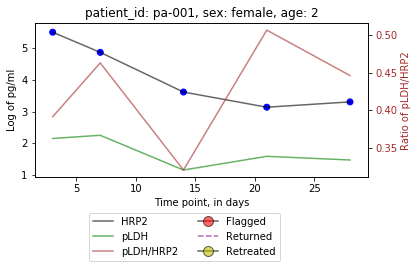

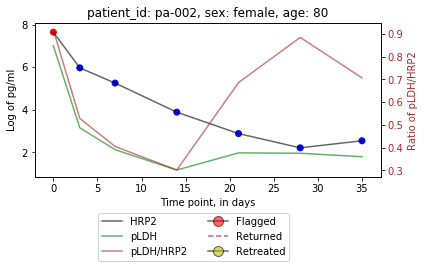

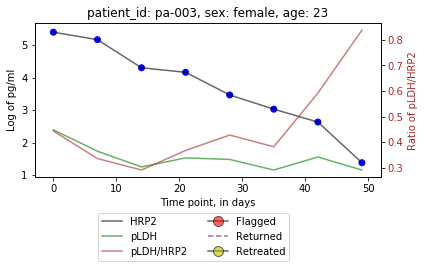

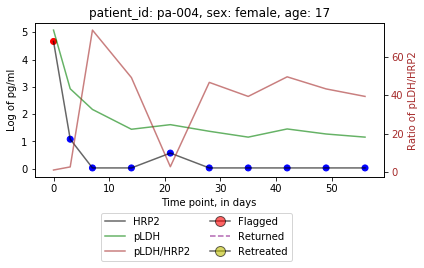

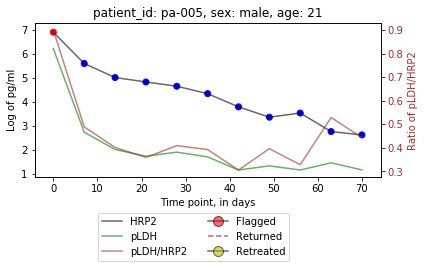

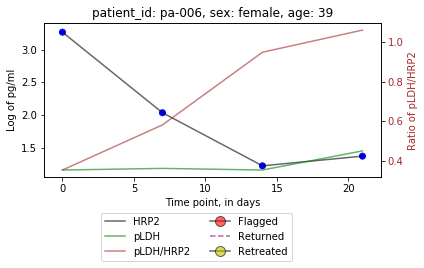

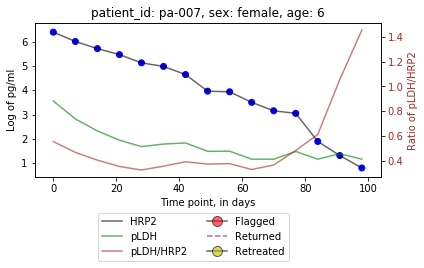

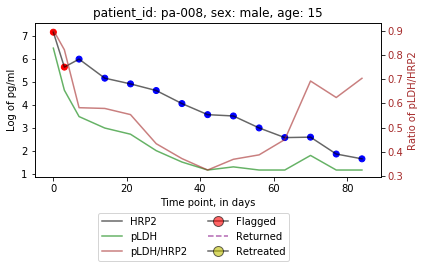

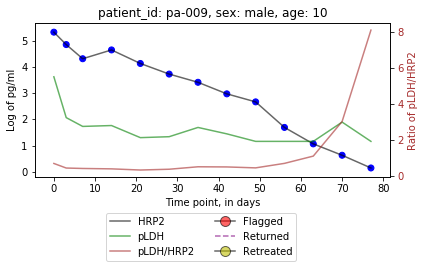

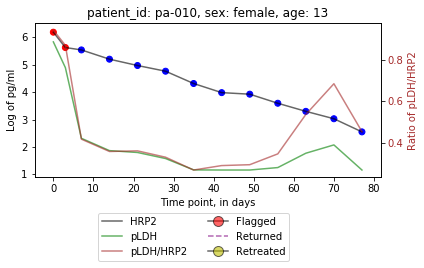

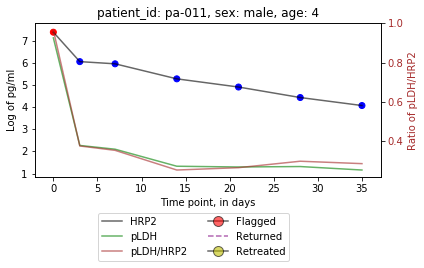

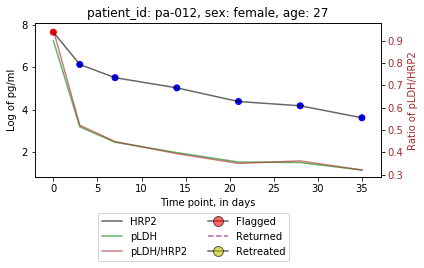

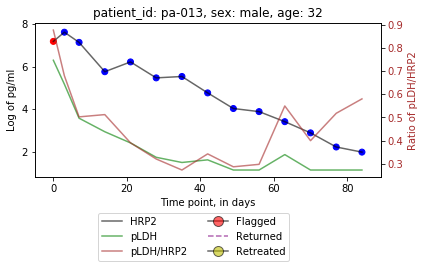

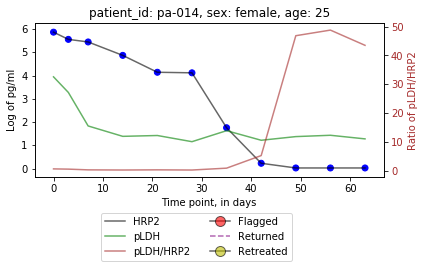

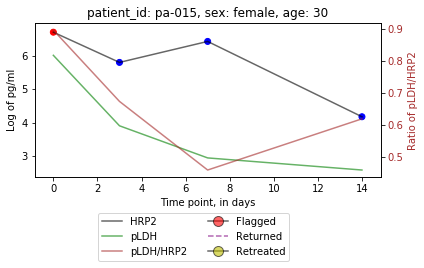

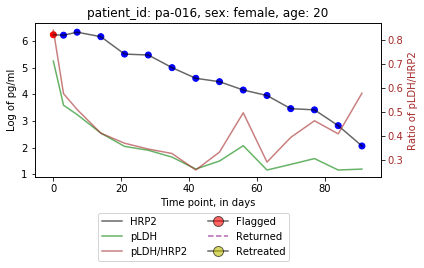

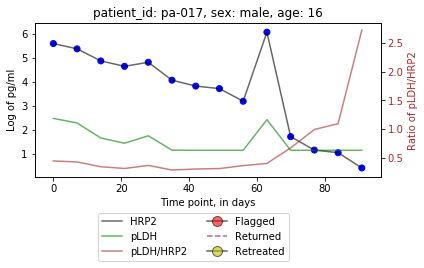

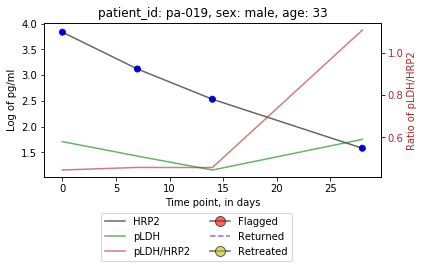

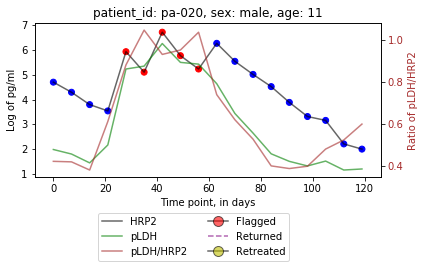

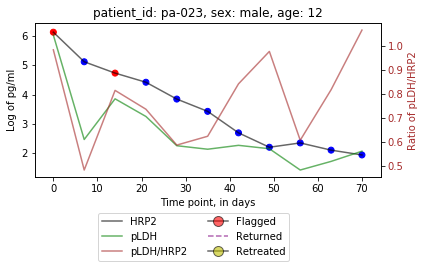

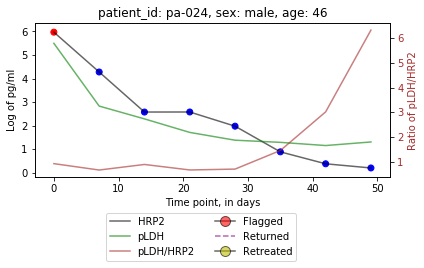

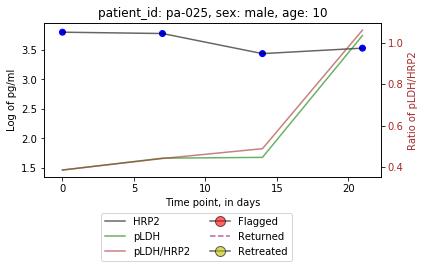

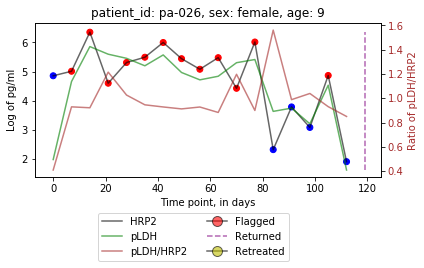

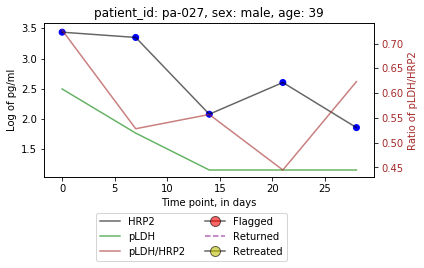

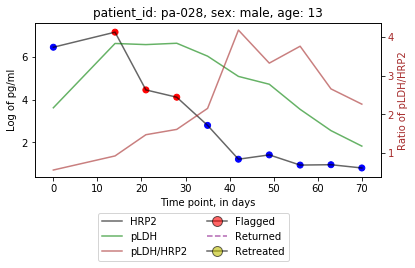

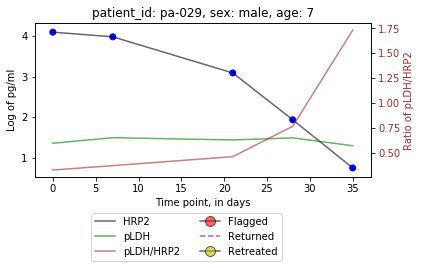

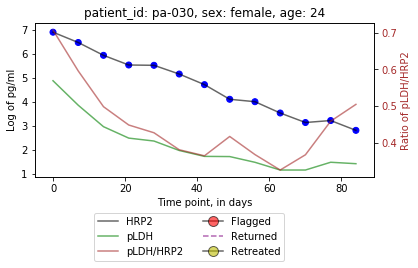

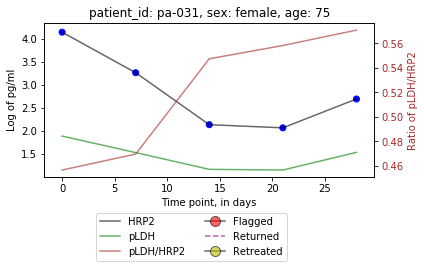

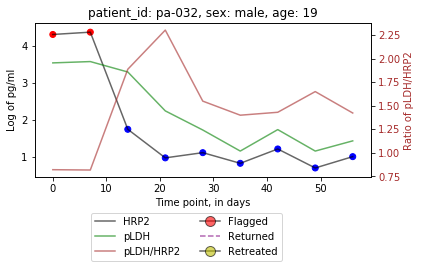

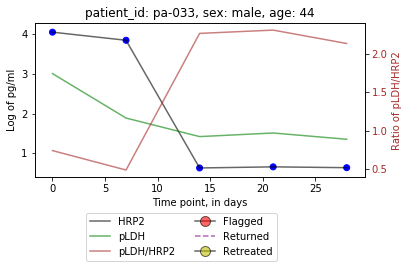

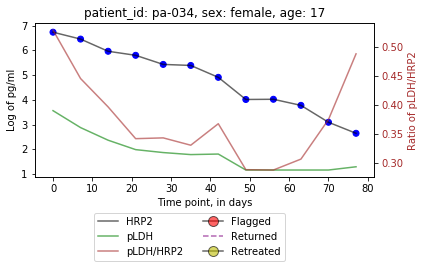

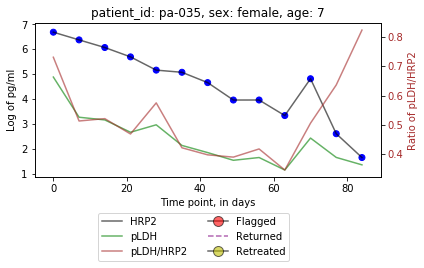

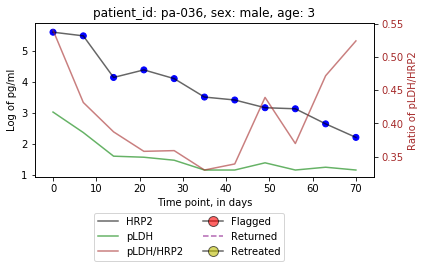

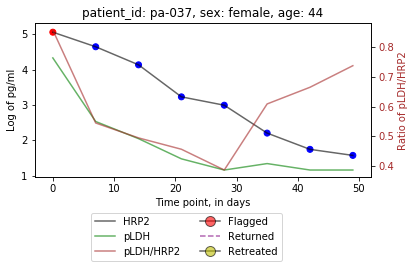

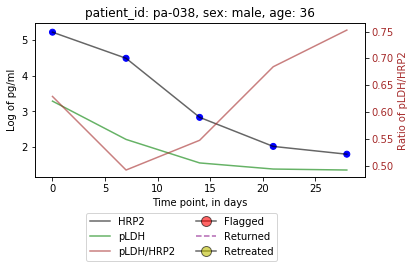

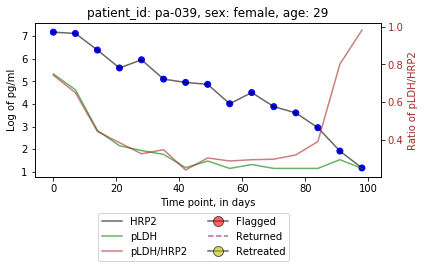

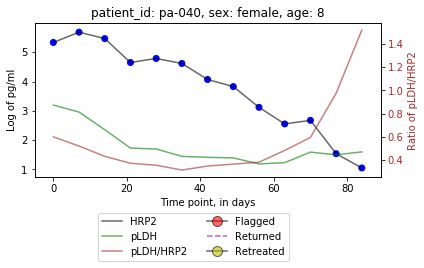

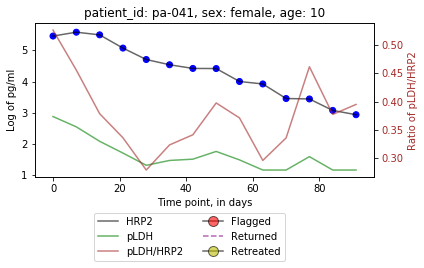

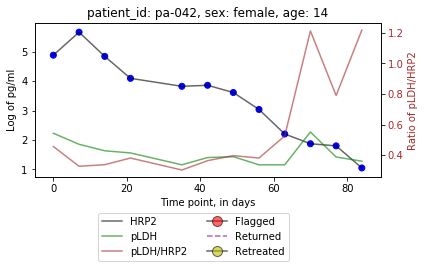

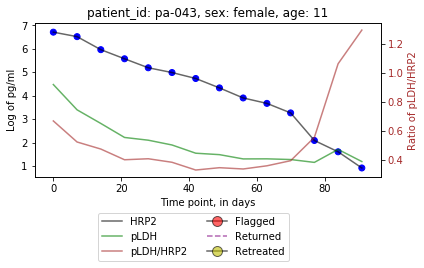

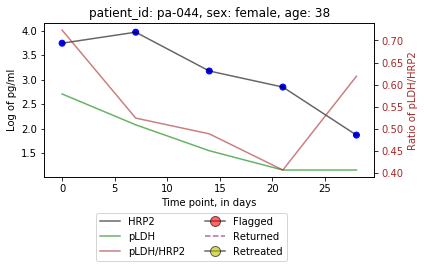

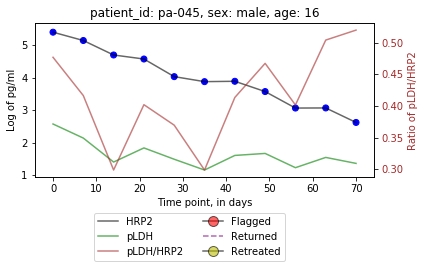

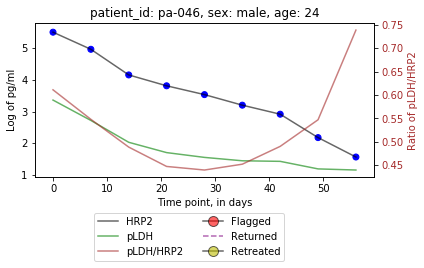

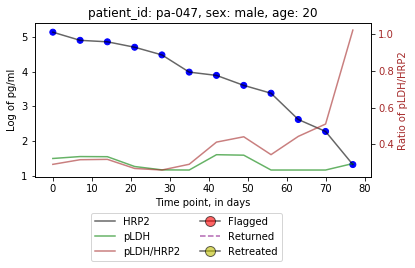

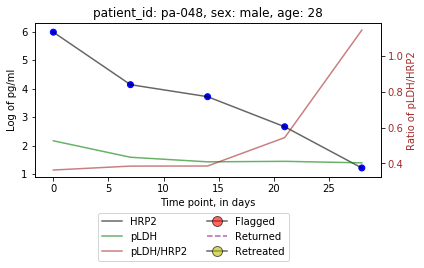

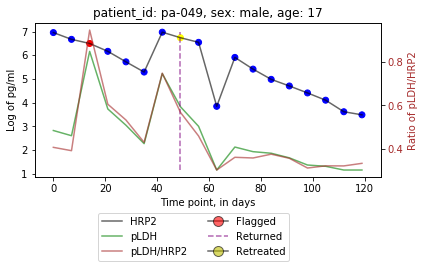

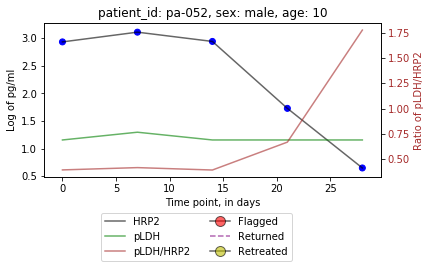

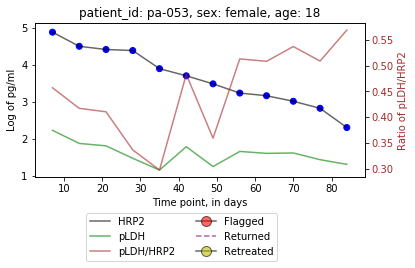

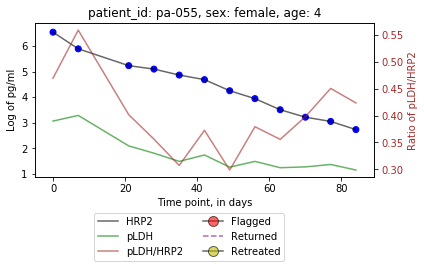

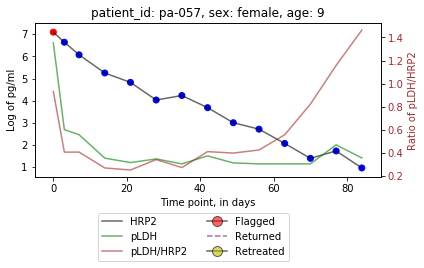

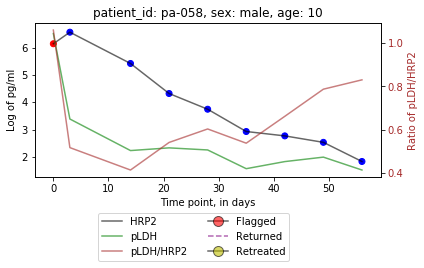

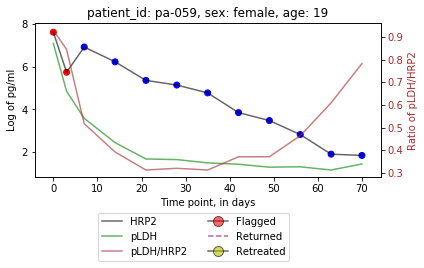

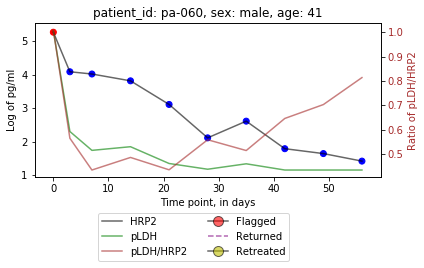

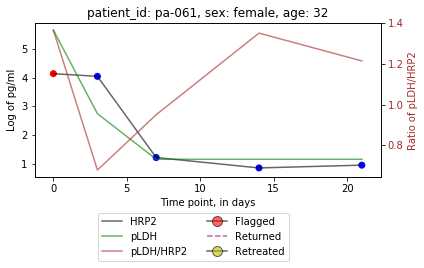

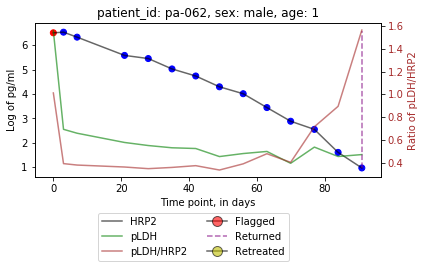

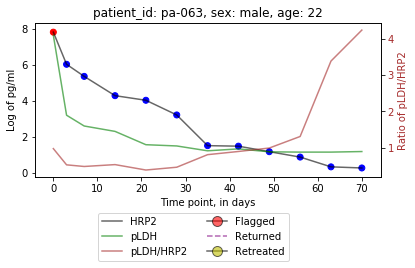

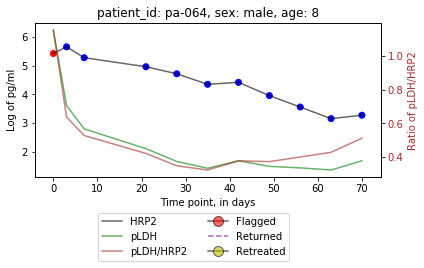

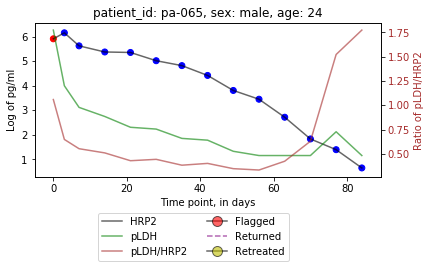

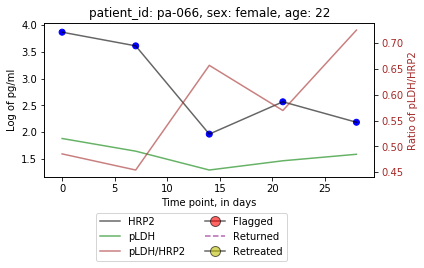

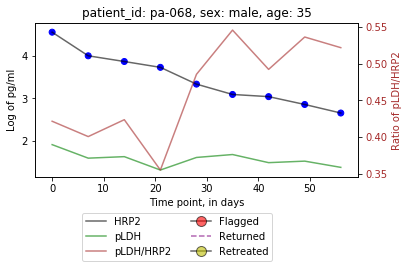

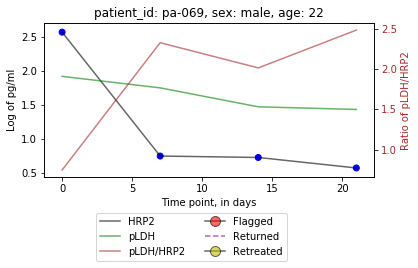

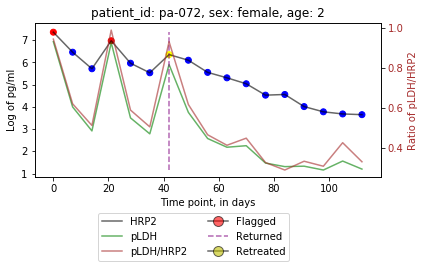

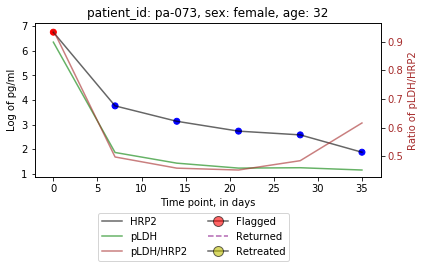

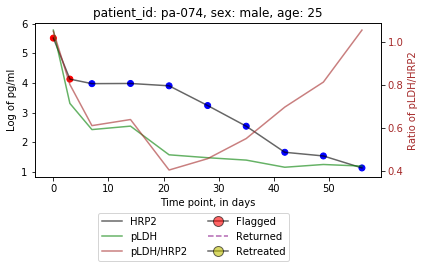

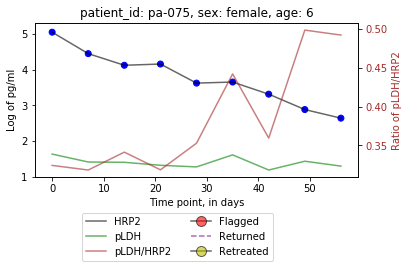

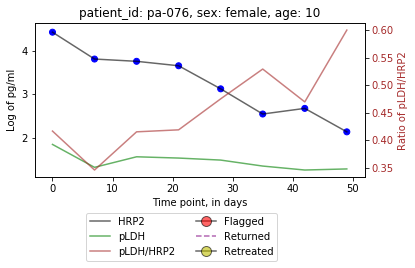

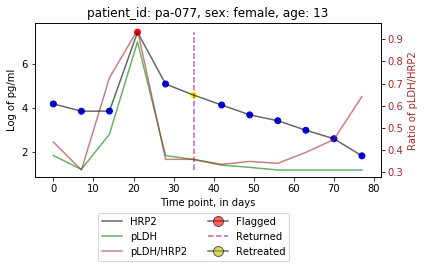

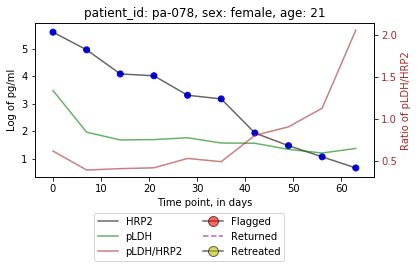

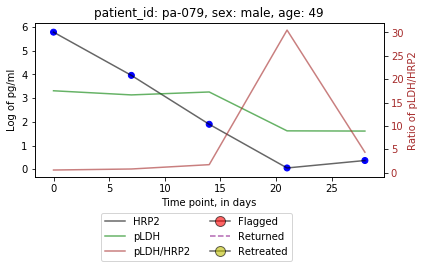

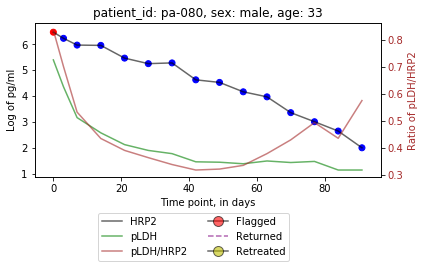

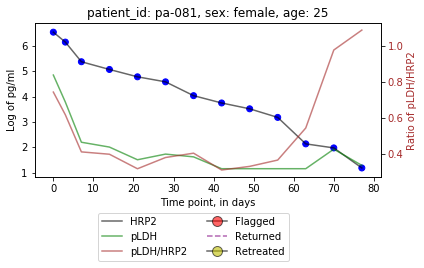

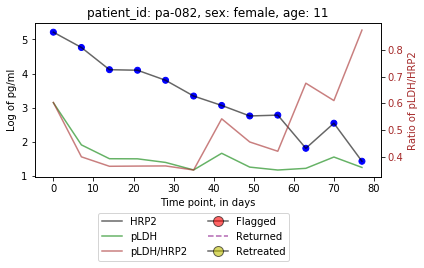

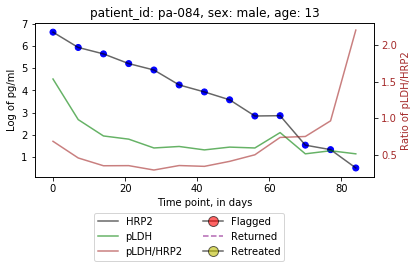

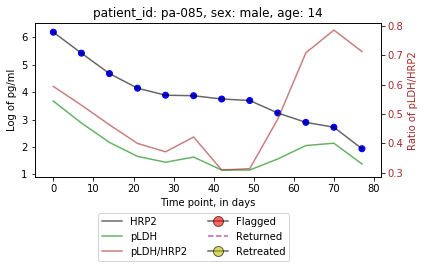

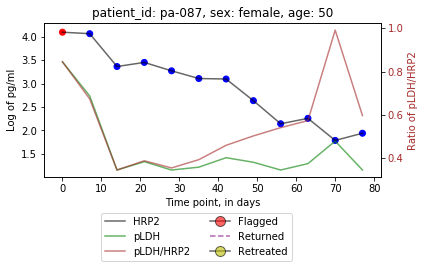

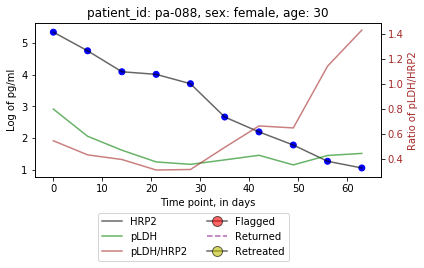

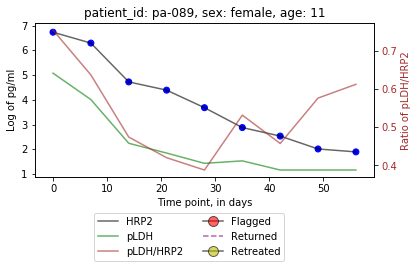

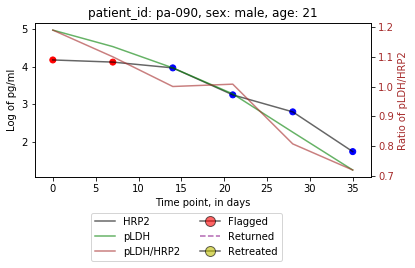

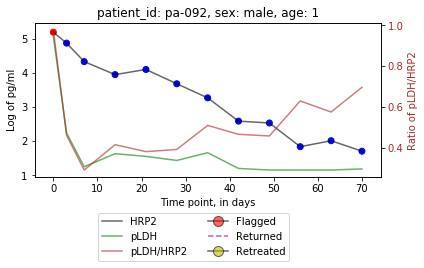

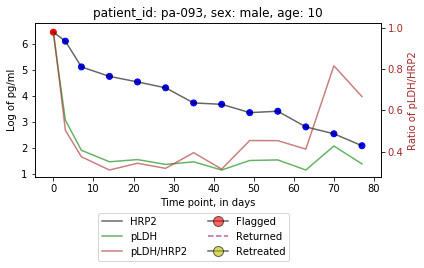

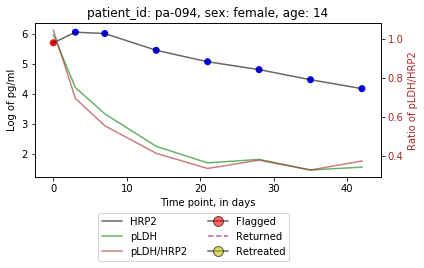

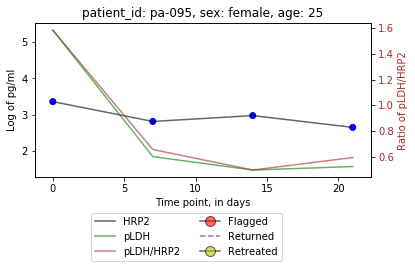

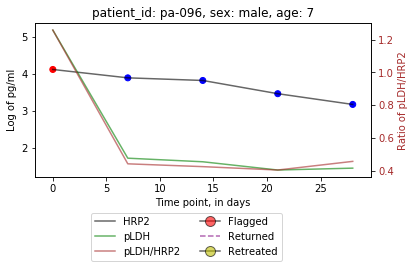

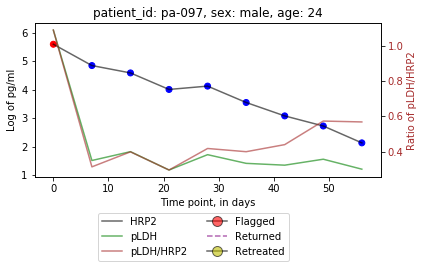

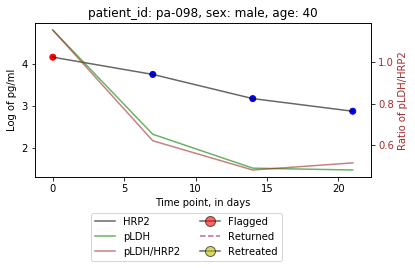

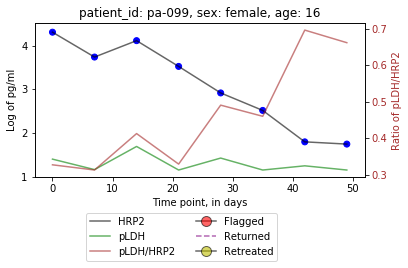

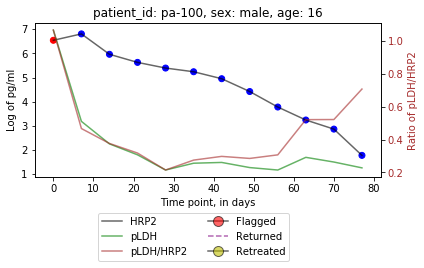

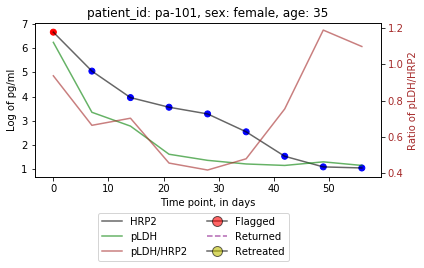

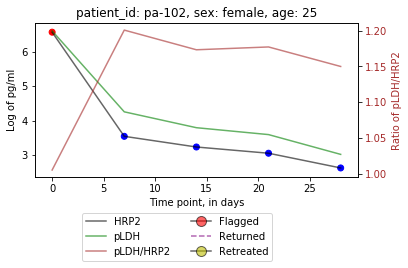

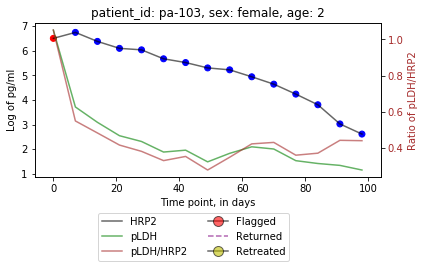

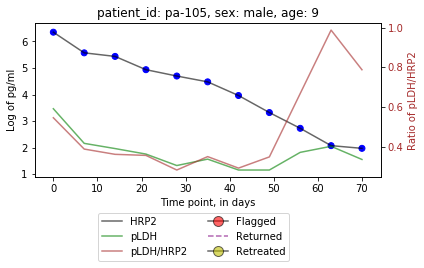

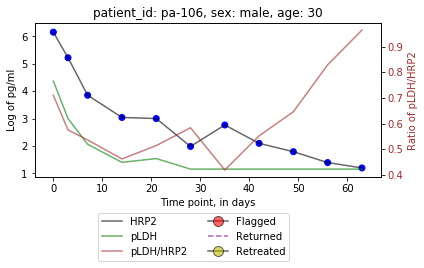

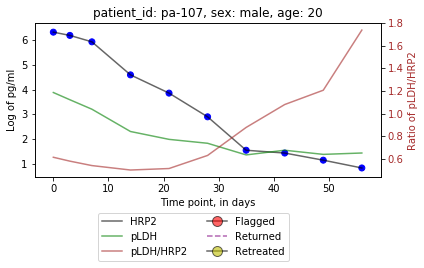

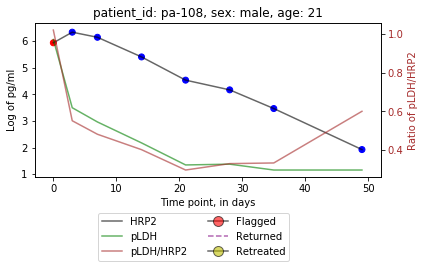

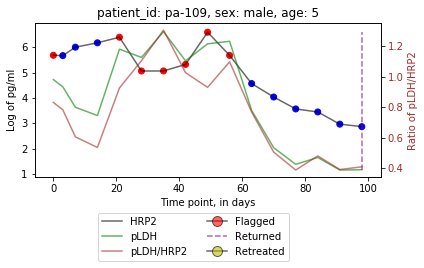

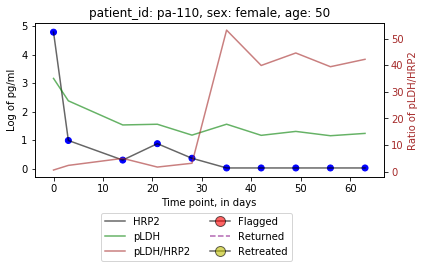

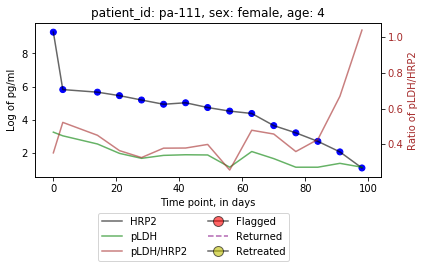

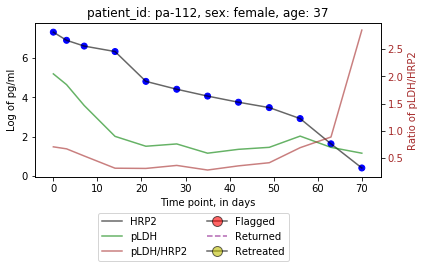

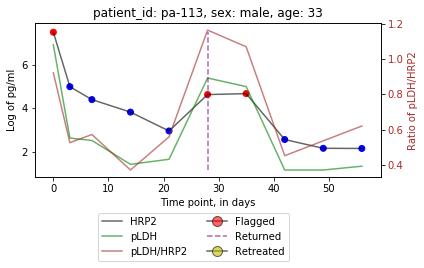

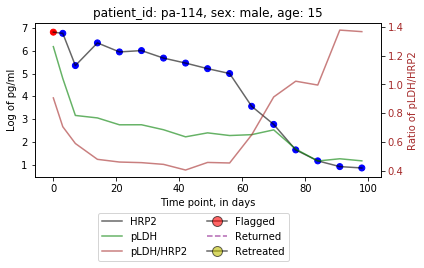

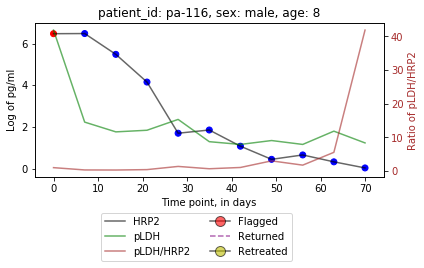

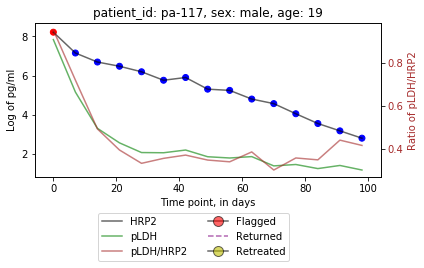

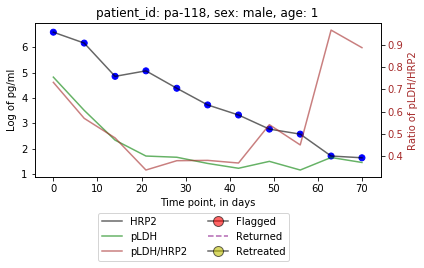

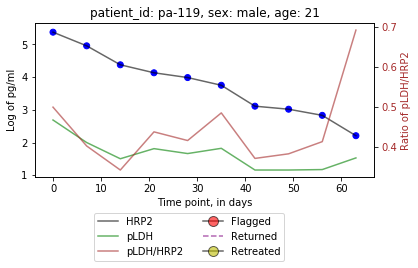

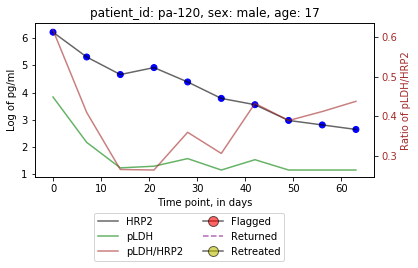

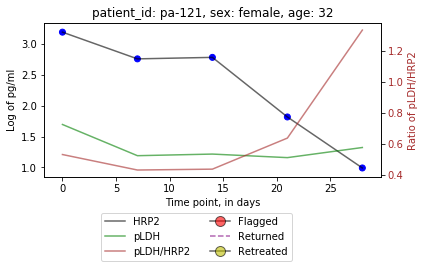

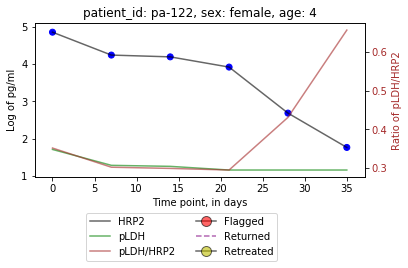

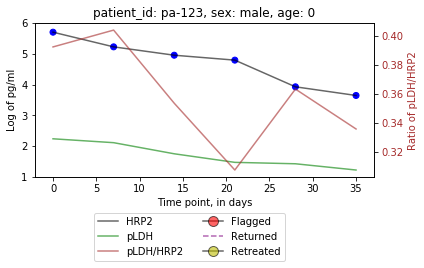

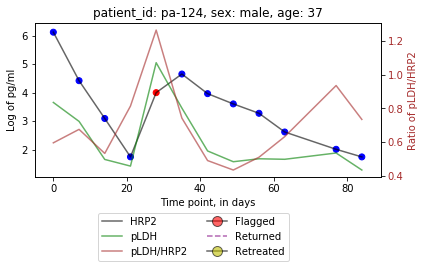

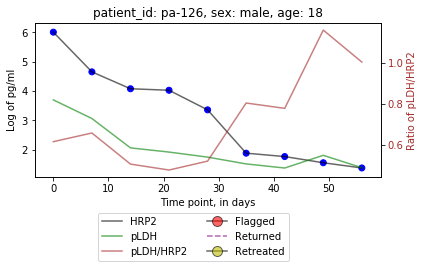

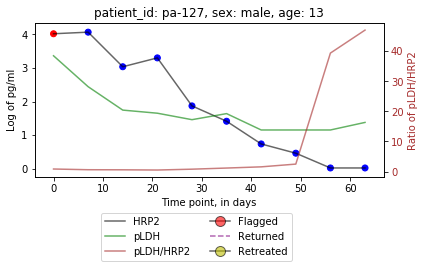

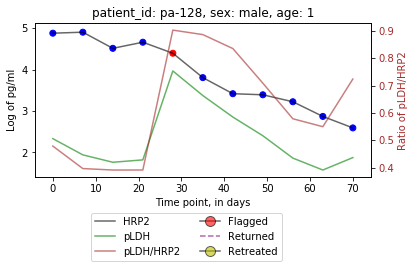

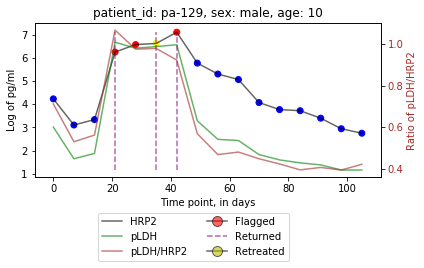

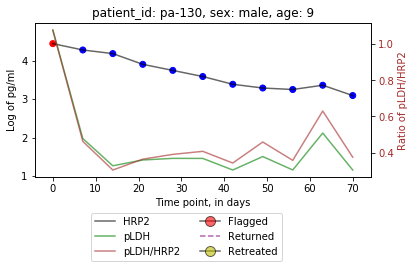

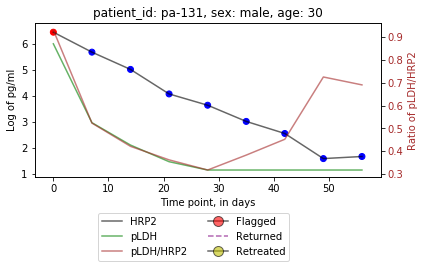

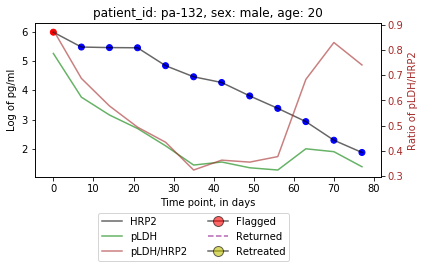

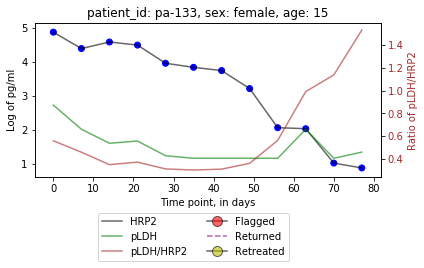

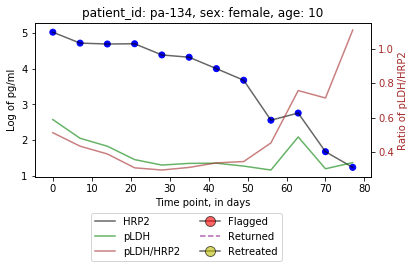

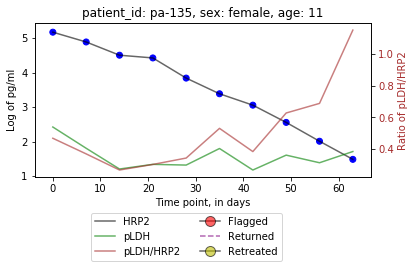

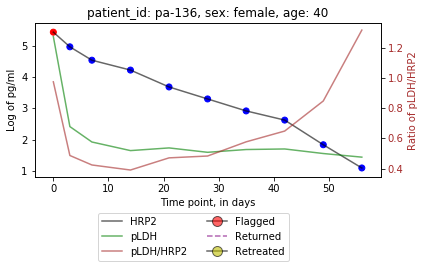

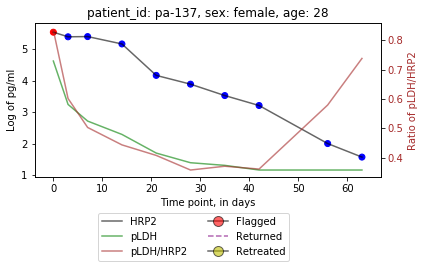

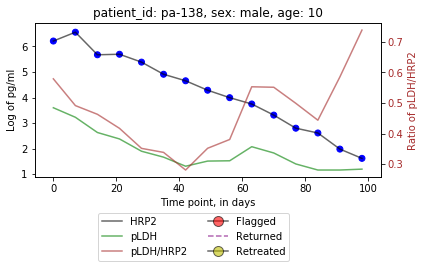

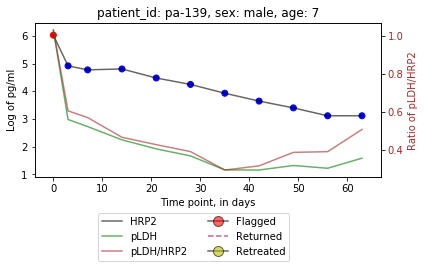

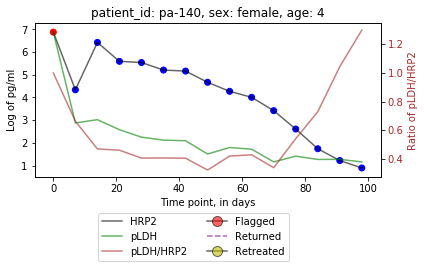

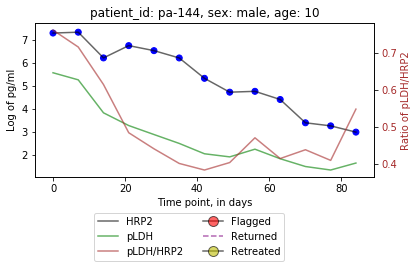

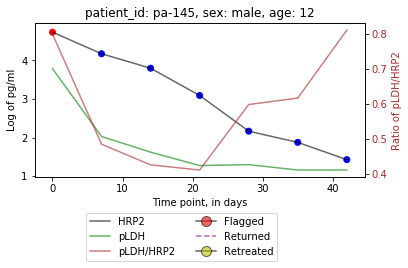

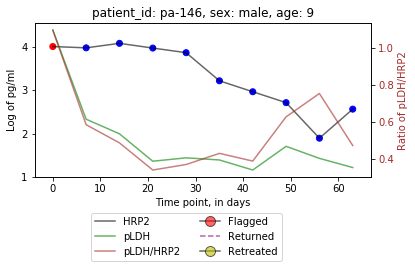

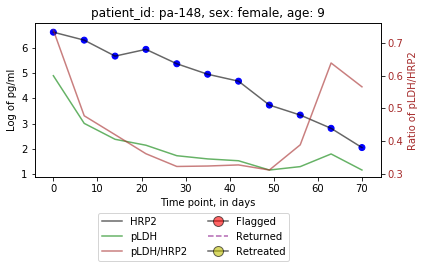

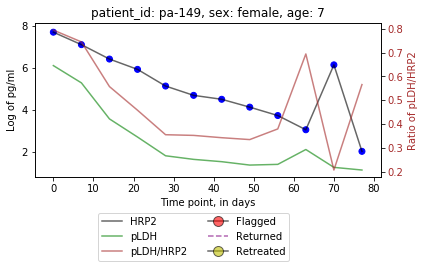

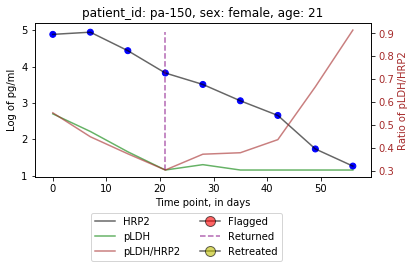

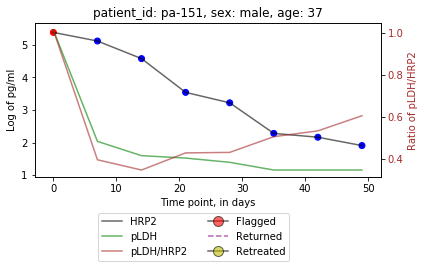

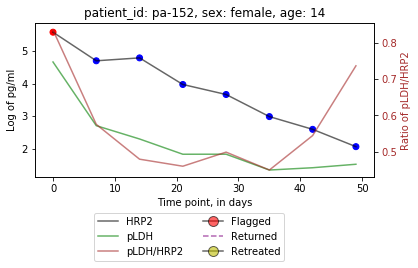

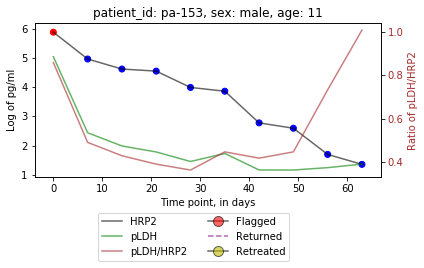

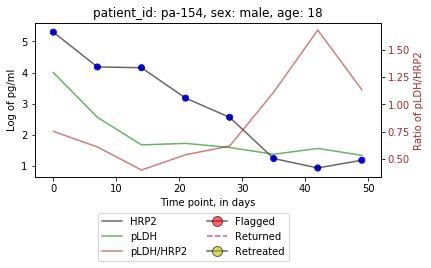

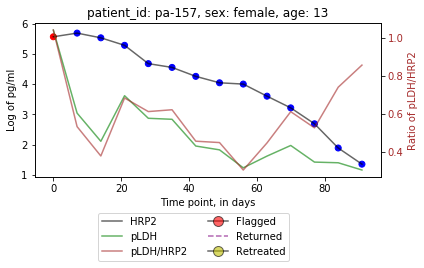

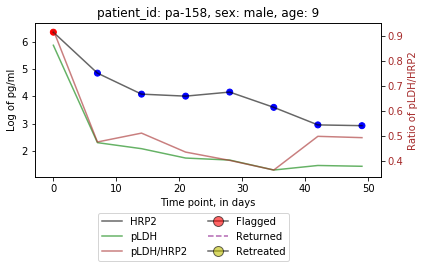

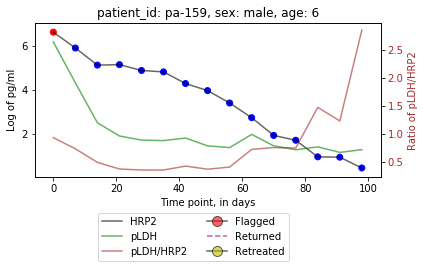

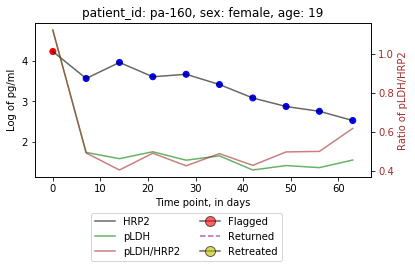

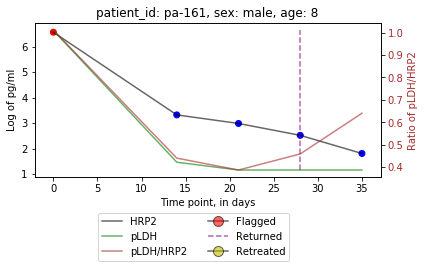

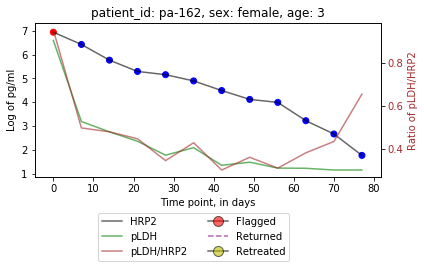

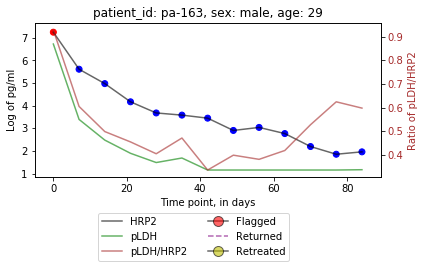

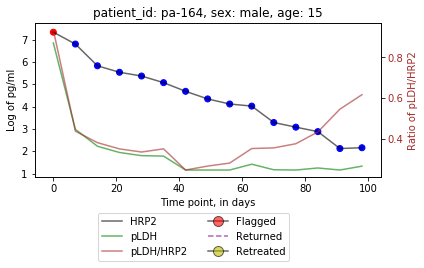

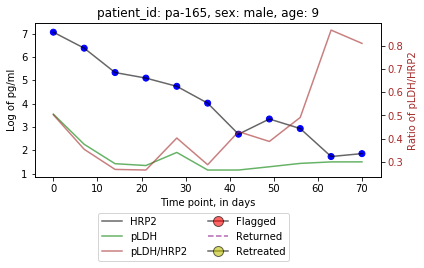

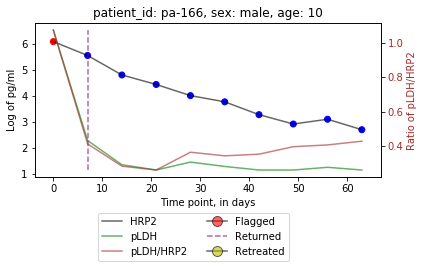

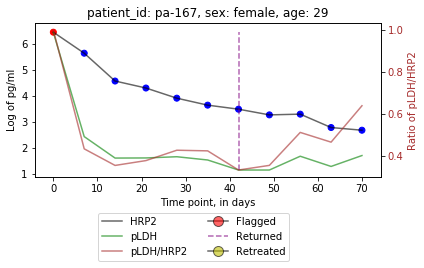

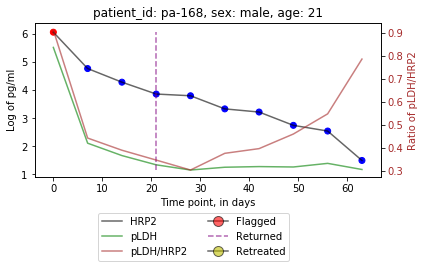

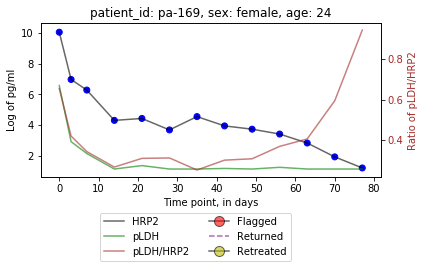

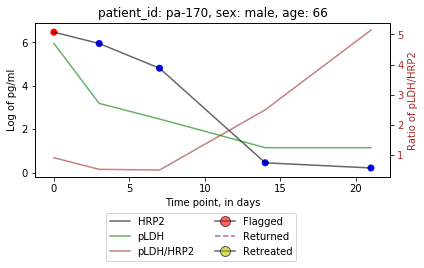

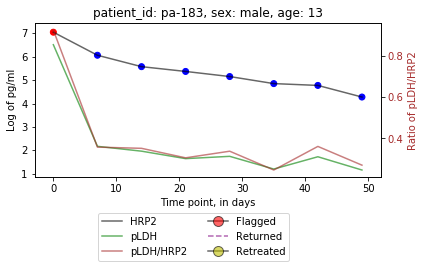

In [29]:
# time_series = PdfPages('C:/Users/lzoeckler/Desktop/4plex/output_data/meta_HRP2_timeseries.pdf')
for pid in rebuilt_data['patient_id'].unique():
# for pid in problem_pids:
    combo = combo_df.loc[combo_df['patient_id'] == pid]
    combo = combo.sort_values('time_point_days')
    max_day = max(combo['time_point_days'])
    max_y = max([max(combo['HRP2_pg_ml']), max(combo['LDH_Pan_pg_ml'])])
    min_y = min([min(combo['HRP2_pg_ml']), min(combo['LDH_Pan_pg_ml'])])
    f, ax1 = plt.subplots()
    sex = combo['sex'].unique()[0]
    age = combo['age'].unique()[0]
    returned = combo['returned_with_fever'].unique()[0]
    when_returned = combo['when_returned_with_fever'].unique()[0]
    if isinstance(when_returned, str):
        try:
            cleaned = [int(when_returned)]
        except ValueError:
            cleaned = when_returned.replace('and ', '')
            cleaned = cleaned.replace(' ', '')
            cleaned = [int(x) for x in cleaned.split(',')]
    else:
        cleaned = []
    retreated = combo['retreated'].unique()[0]
    when_retreated = combo['when_retreated'].unique()[0]
    if ~np.isnan(when_retreated):
        when_retreated = int(when_retreated)
        combo.loc[combo['time_point_days'] == when_retreated, 'group'] = 'yellow'
    title = """patient_id: {}, sex: {}, age: {}""".format(
        pid, sex, age, returned, when_returned, retreated, when_retreated)
    ln4 = ax1.plot(combo['time_point_days'], combo['HRP2_pg_ml'],
                   c='black', alpha=0.6, label='HRP2')
    ln3 = ax1.plot(combo['time_point_days'], combo['LDH_Pan_pg_ml'], c='green', alpha=0.6,
                   label='pLDH')
    ax1.scatter(combo['time_point_days'], combo['HRP2_pg_ml'],
                c=combo['group'])
    for when_returned in cleaned:
        return_line = ax1.plot(np.array([when_returned, when_returned]), np.array([min_y, max_y]),
                       color='purple', linestyle='--', alpha=0.6)
    ax1.set_title(title)
    ax1.set_xlabel('Time point, in days')
    ax1.set_ylabel('Log of pg/ml')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Ratio of pLDH/HRP2', c='brown')
    ln2 = ax2.plot(combo['time_point_days'], combo['ratio'], c='brown', alpha=0.6, label='pLDH/HRP2')
    ax2.tick_params(axis='y', labelcolor='brown')
    
    # LINE STUFF
    lns = ln4 + ln3 + ln2
    lns = lns + [Line2D([0], [0], marker='o', color='k', label='Flagged', markerfacecolor='r',
                        markersize=10, alpha=0.6)]
    lns = lns + [Line2D([0], [0], color='purple', linestyle='--', label='Returned', alpha=0.6)]
    lns = lns + [Line2D([0], [0], marker='o', color='k', label='Retreated', markerfacecolor='y',
                        markersize=10, alpha=0.6)]
    labs = [l.get_label() for l in lns]
#     labs = list(unique_everseen(labs))
    ax2.legend(lns, labs, bbox_to_anchor=(.75, -.2), ncol=2)
    
    f.tight_layout()
#     time_series.savefig(f)
    plt.show()
    plt.close()
# time_series.close()

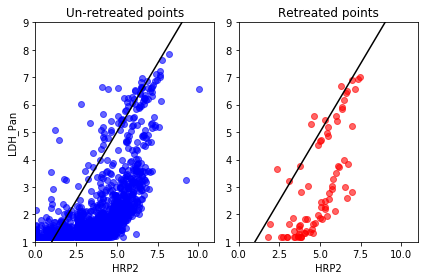

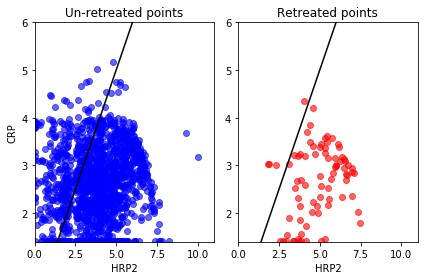

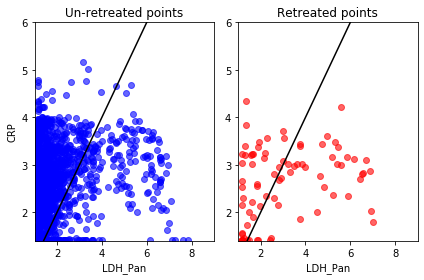

In [176]:
ratios = PdfPages('C:/Users/lzoeckler/Desktop/4plex/output_data/meta_retreated_comparison.pdf')
pairs = [('HRP2_pg_ml', 'LDH_Pan_pg_ml'), ('HRP2_pg_ml', 'CRP_ng_ml'), ('LDH_Pan_pg_ml', 'CRP_ng_ml')]
x = np.linspace(0, 10, 1000)
for pair in pairs:
    name1 = analyte_name_dict[pair[0]][0]
    name2 = analyte_name_dict[pair[1]][0]
    if pair == pairs[0]:
        ylim = (1, 9)
    else:
        ylim = (1.4, 6)
    if pair == pairs[2]:
        xlim = (1, 9)
    else:
        xlim = (0, 11)
    f = plt.figure()
    f.add_subplot()
    # good info
    title = 'Un-retreated points'
    non_retreated = combo_df.loc[~(combo_df['retreated'] == 'Yes')]
    plt.subplot(1,2,1)
    plt.scatter(non_retreated[pair[0]], non_retreated[pair[1]], color='blue', alpha=0.6)
    plt.plot(x, x, color='black')
    plt.title(title)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel(name1)
    plt.ylabel(name2)
    plt.tight_layout()
    # bad info
    title = 'Retreated points'
    retreated = combo_df.loc[combo_df['retreated'] == 'Yes']
    plt.subplot(1,2,2)
    plt.scatter(retreated[pair[0]], retreated[pair[1]], color='red', alpha=0.6)
    plt.plot(x, x, color='black')
    plt.title(title)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel(name1)
    plt.tight_layout()
    ratios.savefig(f)
    plt.show()
    plt.close()
ratios.close()

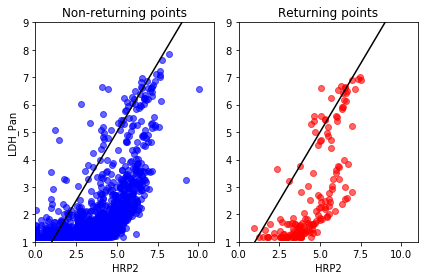

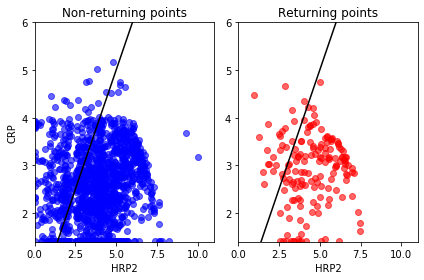

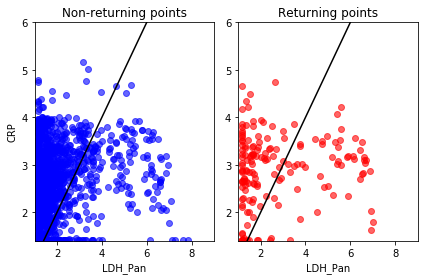

In [179]:
ratios = PdfPages('C:/Users/lzoeckler/Desktop/4plex/output_data/meta_returned_comparison.pdf')
pairs = [('HRP2_pg_ml', 'LDH_Pan_pg_ml'), ('HRP2_pg_ml', 'CRP_ng_ml'), ('LDH_Pan_pg_ml', 'CRP_ng_ml')]
x = np.linspace(0, 10, 1000)
for pair in pairs:
    name1 = analyte_name_dict[pair[0]][0]
    name2 = analyte_name_dict[pair[1]][0]
    if pair == pairs[0]:
        ylim = (1, 9)
    else:
        ylim = (1.4, 6)
    if pair == pairs[2]:
        xlim = (1, 9)
    else:
        xlim = (0, 11)
    f = plt.figure()
    f.add_subplot()
    # good info
    title = 'Non-returning points'
    non_retreated = combo_df.loc[~(combo_df['returned_with_fever'] == 'Yes')]
    plt.subplot(1,2,1)
    plt.scatter(non_retreated[pair[0]], non_retreated[pair[1]], color='blue', alpha=0.6)
    plt.plot(x, x, color='black')
    plt.title(title)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel(name1)
    plt.ylabel(name2)
    plt.tight_layout()
    # bad info
    title = 'Returning points'
    retreated = combo_df.loc[combo_df['returned_with_fever'] == 'Yes']
    plt.subplot(1,2,2)
    plt.scatter(retreated[pair[0]], retreated[pair[1]], color='red', alpha=0.6)
    plt.plot(x, x, color='black')
    plt.title(title)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel(name1)
    plt.tight_layout()
    ratios.savefig(f)
    plt.show()
    plt.close()
ratios.close()

In [ ]:
ratios = PdfPages('C:/Users/lzoeckler/Desktop/4plex/output_data/meta_returned_good_vs_bad_comparison.pdf')
pairs = [('HRP2_pg_ml', 'LDH_Pan_pg_ml'), ('HRP2_pg_ml', 'CRP_ng_ml'), ('LDH_Pan_pg_ml', 'CRP_ng_ml')]
x = np.linspace(0, 10, 1000)
for pair in pairs:
    name1 = analyte_name_dict[pair[0]][0]
    name2 = analyte_name_dict[pair[1]][0]
    if pair == pairs[0]:
        ylim = (1, 9)
    else:
        ylim = (1.4, 6)
    if pair == pairs[2]:
        xlim = (1, 9)
    else:
        xlim = (0, 11)
    f = plt.figure()
    f.add_subplot()
    # good info
    title = 'All un-retreated points and retreated good points'
    non_retreated = combo_df.loc[~(combo_df['retreated'] == 'Yes')]
    good_df = non_retreated.loc[non_retreated['group'] == 'blue']
    plt.subplot(1,2,1)
    plt.scatter(good_df[pair[0]], good_df[pair[1]], color='blue', alpha=0.6)
    plt.plot(x, x, color='black')
    plt.title(title)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel(name1)
    plt.ylabel(name2)
    plt.tight_layout()
    # bad info
    title = 'Retreated bad points'
    retreated = combo_df.loc[combo_df['retreated'] == 'Yes']
    good_df = non_retreated.loc[non_retreated['group'] == 'blue']
    plt.subplot(1,2,2)
    plt.scatter(retreated[pair[0]], retreated[pair[1]], color='red', alpha=0.6)
    plt.plot(x, x, color='black')
    plt.title(title)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel(name1)
    plt.tight_layout()
    ratios.savefig(f)
    plt.show()
    plt.close()
ratios.close()